In [1]:
## imports
import pandas as pd
import numpy as np
import re
import requests
import yaml
import pickle
from statistics import mean
import os

import census
import janitor
from census import Census
import us
from us import states

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd


import contextily as ctx
## repeated printouts
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_colwidth', None)

import warnings
warnings.filterwarnings("ignore")

In [2]:
pwd

'C:\\Users\\Lahiri\\Gentrification\\Predicting-Gentrification-in-DC\\Unsup and Sup learning'

### Calling cleaned dataset

In [3]:
acs_9yr_imputed = pd.read_hdf('../acs_pre_clustering.h5', 'acs')

### Subsetting for 2012 and 2021 data

In [4]:
proper_tracts = pd.DataFrame(acs_9yr_imputed.tract.value_counts()) #proper tracts are the ones for whom we have 10 years of data
proper_tracts_list =  proper_tracts[proper_tracts.tract == 10].reset_index()['index'].unique().tolist() 

#subset for 'proper tracts'
acs_9yr_cluster = acs_9yr_imputed[(acs_9yr_imputed.tract.isin(proper_tracts_list))]

#subset for years between which we are looking at change in variables
acs_9yr_cluster = acs_9yr_cluster[(acs_9yr_cluster.Year == 2012) | (acs_9yr_cluster.Year == 2021)]

### Pivoting to calculate % changes for each variable

In [5]:
acs_9yr_cluster_wide = acs_9yr_cluster.pivot_wider(
    index = 'tract', 
    names_from = 'Year', 
    values_from = ['tot_pop',
                  'prop_black',
                  'prop_nwhite', 
                  'prop_bach',
                  'pcap_inc_overall',
                  'pcap_inc_w',
                  'pcap_inc_b',
                  'perc_fem',
                  'perc_young_pop',
                   'prop_long_res',
                  'median_hous',
                  'median_rent'],
    names_glue = "{_value}_{Year}"
  )


In [6]:
for i in list(acs_9yr_cluster.iloc[:,4:].columns):
    acs_9yr_cluster_wide['perc_change_'+str(i)] = (acs_9yr_cluster_wide[str(i)+ '_'+str(2021)]-acs_9yr_cluster_wide[str(i)+ '_'+str(2012)])/acs_9yr_cluster_wide[str(i)+ '_' + str(2012)]
    
acs_final = acs_9yr_cluster_wide[[col for col in acs_9yr_cluster_wide.columns if 'perc_change' in col or 'tract' in col]]
acs_final.drop(21, inplace = True)
cluster_features = acs_final[['perc_change_prop_nwhite','perc_change_prop_bach', 
              'perc_change_pcap_inc_overall', 
              'perc_change_median_hous','perc_change_median_rent']]    

### Hierarchical Clustering

In [7]:
hierarchical_cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
labels = hierarchical_cluster.fit_predict(cluster_features)

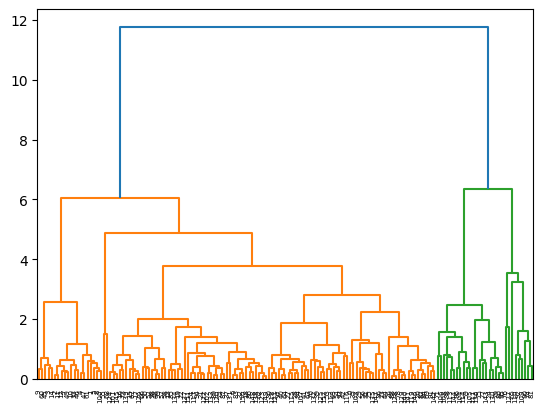

In [8]:
dendrogram = sch.dendrogram(sch.linkage(cluster_features, method = 'ward'))

In [9]:
g= globals()
cluster_df= pd.DataFrame(cluster_features)
cluster_df = cluster_df.rename(columns = {0:'perc_change_prop_nwhite',1:'perc_change_prop_bach', 2:
              'perc_change_pcap_inc_overall',3:'perc_change_median_hous',4:'perc_change_median_rent'})

## Mean of variables for each cluster
for i in range(0,4):
    varname = 'cluster_{}'.format(i)
    g[varname] = pd.DataFrame(cluster_df[labels == i].mean()).rename(columns = {0:'mean'}).reset_index()

dc = pd.DataFrame(cluster_df.mean()).rename(columns = {0:'mean'}).reset_index()

In [10]:
for i in range(0,4):
    varname = 'index_{}'.format(i)
    g[varname] = cluster_df[labels == i].index.values.tolist()

#Creating new variable reflecting gentrificaition status
acs_final['label'] = np.where(acs_final.index.isin(index_0),'stable',0)
acs_final['label'] = np.where(acs_final.index.isin(index_1),'gentrifying',acs_final['label'])
acs_final['label'] = np.where(acs_final.index.isin(index_2),'intense gentrification',acs_final['label'])
acs_final['label'] = np.where(acs_final.index.isin(index_3),'affordable',acs_final['label'])

In [11]:
acs_final.to_hdf('../acs_clustered.h5', key='acs', mode='w')

In [12]:
cluster_0['label'] = 'stable'
cluster_1['label'] = 'gentrifying'
cluster_2['label'] = 'intense gentrification'
cluster_3['label'] = 'affordable'
dc['label'] = 'DC average'


for i in ['cluster_0','cluster_1','cluster_2','cluster_3','dc']:
    varname = i+'_wide'
    g[varname] = pd.pivot(g[i], index='index', columns = 'label', values ='mean')

plot_df = dc_wide.merge(cluster_0_wide,on='index').merge(cluster_1_wide,on='index').merge(cluster_2_wide,on='index').merge(cluster_3_wide,on='index')
plot_df = plot_df.reset_index()


### Visualizing results from clustering

([<matplotlib.axis.YTick at 0x1cb1b11eaa0>,
 [Text(0, 1, 'perc_change_median_hous'),
  Text(0, 2, 'perc_change_median_rent'),
  Text(0, 3, 'perc_change_pcap_inc_overall'),
  Text(0, 4, 'perc_change_prop_bach'),
  Text(0, 5, 'perc_change_prop_nwhite')])

Text(0.0, 1.0, 'Comparison of DC average and stable tracts')

([<matplotlib.axis.XTick at 0x1cb1b11e950>,
 [Text(-0.2, 0, '−0.2'),
  Text(0.0, 0, '0.0'),
  Text(0.2, 0, '0.2'),
  Text(0.4, 0, '0.4'),
  Text(0.6, 0, '0.6'),
  Text(0.8, 0, '0.8'),
  Text(1.0, 0, '1.0'),
  Text(1.2, 0, '1.2'),
  Text(1.4, 0, '1.4'),
  Text(1.6, 0, '1.6'),
  Text(1.8, 0, '1.8'),
  Text(2.0, 0, '2.0'),
  Text(2.2, 0, '2.2'),
  Text(2.4, 0, '2.4'),
  Text(2.6, 0, '2.6'),
  Text(2.8, 0, '2.8'),
  Text(3.0, 0, '3.0'),
  Text(3.2, 0, '3.2')])

Text(0.5, 0, '% change in variables')

Text(0, 0.5, 'Metrics')

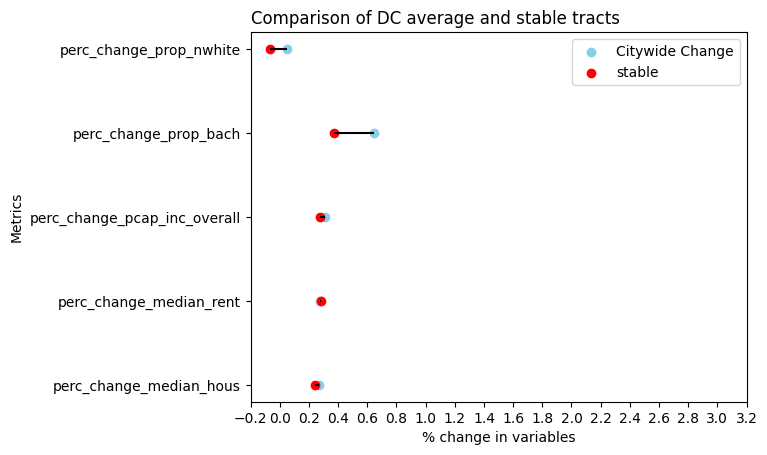

([<matplotlib.axis.YTick at 0x1cb1aa7e590>,
 [Text(0, 1, 'perc_change_median_hous'),
  Text(0, 2, 'perc_change_median_rent'),
  Text(0, 3, 'perc_change_pcap_inc_overall'),
  Text(0, 4, 'perc_change_prop_bach'),
  Text(0, 5, 'perc_change_prop_nwhite')])

Text(0.0, 1.0, 'Comparison of DC average and gentrifying tracts')

([<matplotlib.axis.XTick at 0x1cb1aa7d8d0>,
 [Text(-0.2, 0, '−0.2'),
  Text(0.0, 0, '0.0'),
  Text(0.2, 0, '0.2'),
  Text(0.4, 0, '0.4'),
  Text(0.6, 0, '0.6'),
  Text(0.8, 0, '0.8'),
  Text(1.0, 0, '1.0'),
  Text(1.2, 0, '1.2'),
  Text(1.4, 0, '1.4'),
  Text(1.6, 0, '1.6'),
  Text(1.8, 0, '1.8'),
  Text(2.0, 0, '2.0'),
  Text(2.2, 0, '2.2'),
  Text(2.4, 0, '2.4'),
  Text(2.6, 0, '2.6'),
  Text(2.8, 0, '2.8'),
  Text(3.0, 0, '3.0'),
  Text(3.2, 0, '3.2')])

Text(0.5, 0, '% change in variables')

Text(0, 0.5, 'Metrics')

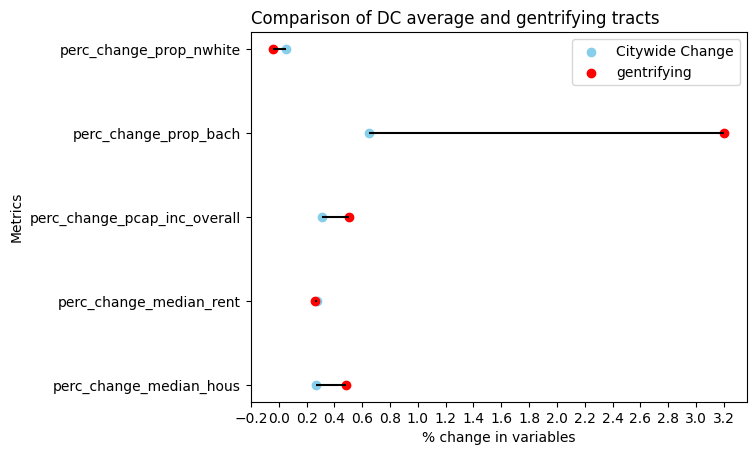

([<matplotlib.axis.YTick at 0x1cb1af662f0>,
 [Text(0, 1, 'perc_change_median_hous'),
  Text(0, 2, 'perc_change_median_rent'),
  Text(0, 3, 'perc_change_pcap_inc_overall'),
  Text(0, 4, 'perc_change_prop_bach'),
  Text(0, 5, 'perc_change_prop_nwhite')])

Text(0.0, 1.0, 'Comparison of DC average and intense gentrification tracts')

([<matplotlib.axis.XTick at 0x1cb1aadb460>,
 [Text(-0.2, 0, '−0.2'),
  Text(0.0, 0, '0.0'),
  Text(0.2, 0, '0.2'),
  Text(0.4, 0, '0.4'),
  Text(0.6, 0, '0.6'),
  Text(0.8, 0, '0.8'),
  Text(1.0, 0, '1.0'),
  Text(1.2, 0, '1.2'),
  Text(1.4, 0, '1.4'),
  Text(1.6, 0, '1.6'),
  Text(1.8, 0, '1.8'),
  Text(2.0, 0, '2.0'),
  Text(2.2, 0, '2.2'),
  Text(2.4, 0, '2.4'),
  Text(2.6, 0, '2.6'),
  Text(2.8, 0, '2.8'),
  Text(3.0, 0, '3.0'),
  Text(3.2, 0, '3.2')])

Text(0.5, 0, '% change in variables')

Text(0, 0.5, 'Metrics')

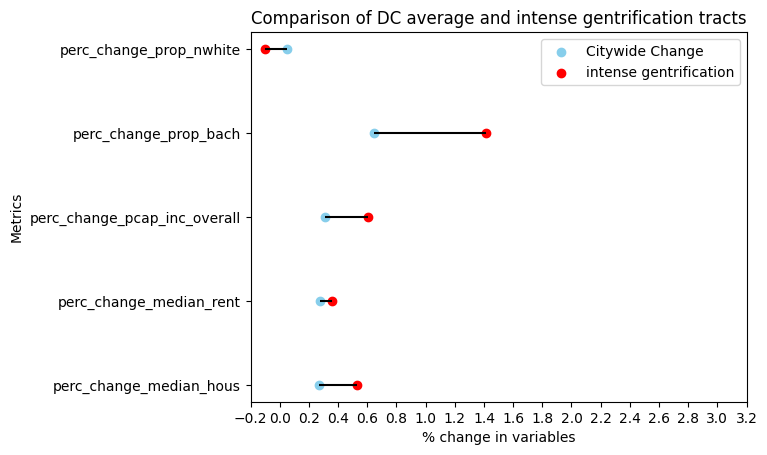

([<matplotlib.axis.YTick at 0x1cb1b0061d0>,
 [Text(0, 1, 'perc_change_median_hous'),
  Text(0, 2, 'perc_change_median_rent'),
  Text(0, 3, 'perc_change_pcap_inc_overall'),
  Text(0, 4, 'perc_change_prop_bach'),
  Text(0, 5, 'perc_change_prop_nwhite')])

Text(0.0, 1.0, 'Comparison of DC average and affordable tracts')

([<matplotlib.axis.XTick at 0x1cb1b005510>,
 [Text(-0.2, 0, '−0.2'),
  Text(0.0, 0, '0.0'),
  Text(0.2, 0, '0.2'),
  Text(0.4, 0, '0.4'),
  Text(0.6, 0, '0.6'),
  Text(0.8, 0, '0.8'),
  Text(1.0, 0, '1.0'),
  Text(1.2, 0, '1.2'),
  Text(1.4, 0, '1.4'),
  Text(1.6, 0, '1.6'),
  Text(1.8, 0, '1.8'),
  Text(2.0, 0, '2.0'),
  Text(2.2, 0, '2.2'),
  Text(2.4, 0, '2.4'),
  Text(2.6, 0, '2.6'),
  Text(2.8, 0, '2.8'),
  Text(3.0, 0, '3.0'),
  Text(3.2, 0, '3.2')])

Text(0.5, 0, '% change in variables')

Text(0, 0.5, 'Metrics')

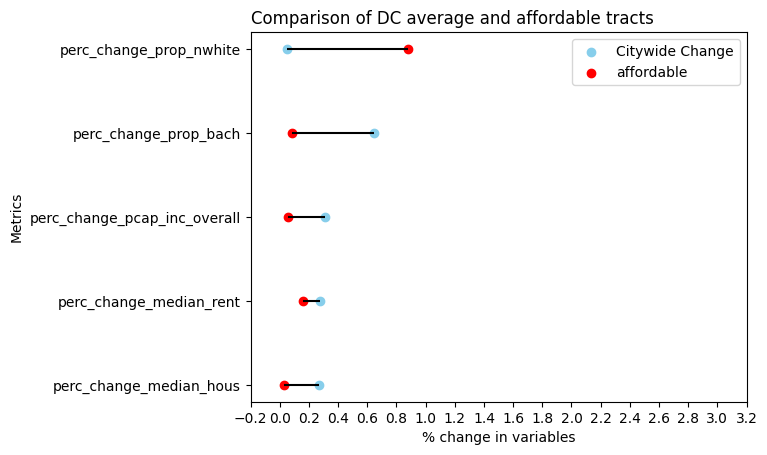

In [13]:
for i in ['stable','gentrifying','intense gentrification','affordable']:
    
    plt.hlines(y=range(1,len(plot_df.index)+1), xmin=plot_df['DC average'], xmax=plot_df[i],color='black')
    plt.scatter(plot_df['DC average'], range(1,len(plot_df.index)+1), color='skyblue', alpha=1, label='Citywide Change')
    plt.scatter(plot_df[i], range(1,len(plot_df.index)+1), color='red', alpha=1 , label=i)
    plt.legend()

    # Add title and axis names
    plt.yticks(range(1,len(plot_df.index)+1), plot_df['index'])
    plt.title('Comparison of DC average and ' + str(i)+' tracts', loc='left')
    plt.xticks([-0.2,0,0.2,0.4,0.6,0.8,1,1.2,1.4,1.6,1.8,2,2.2,2.4,2.6,2.8,3,3.2])
    plt.xlabel('% change in variables')
    plt.ylabel('Metrics')
    plt.show()

In [14]:
a= pd.concat([cluster_0,cluster_1,cluster_2,cluster_3])

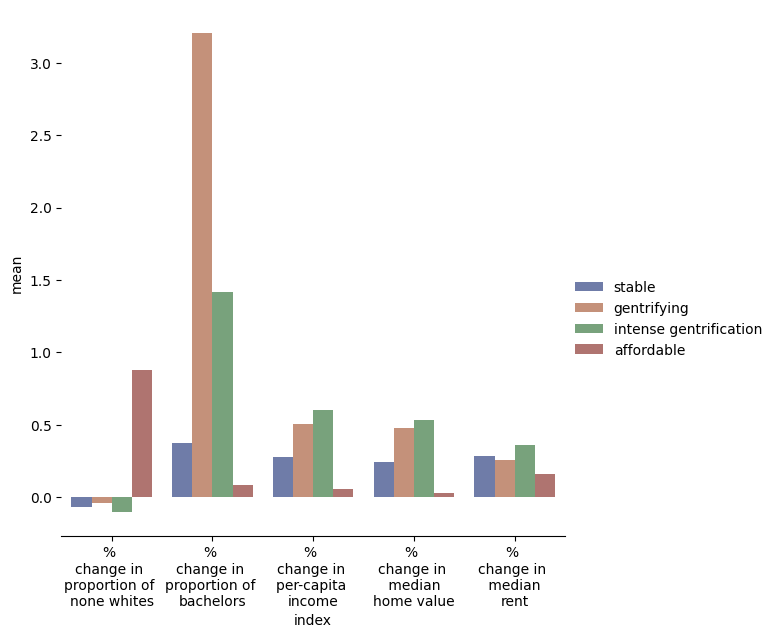

In [15]:
g = sns.catplot(
    data=a, kind="bar",
    x="index", y="mean", hue="label",
    errorbar="sd", palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_xticklabels(['% \nchange in \nproportion of \nnone whites','% \nchange in \nproportion of \nbachelors',
           '% \nchange in \nper-capita \nincome','% \nchange in \n median \nhome value',
           '% \nchange in \n median \nrent'])
g.legend.set_title("")


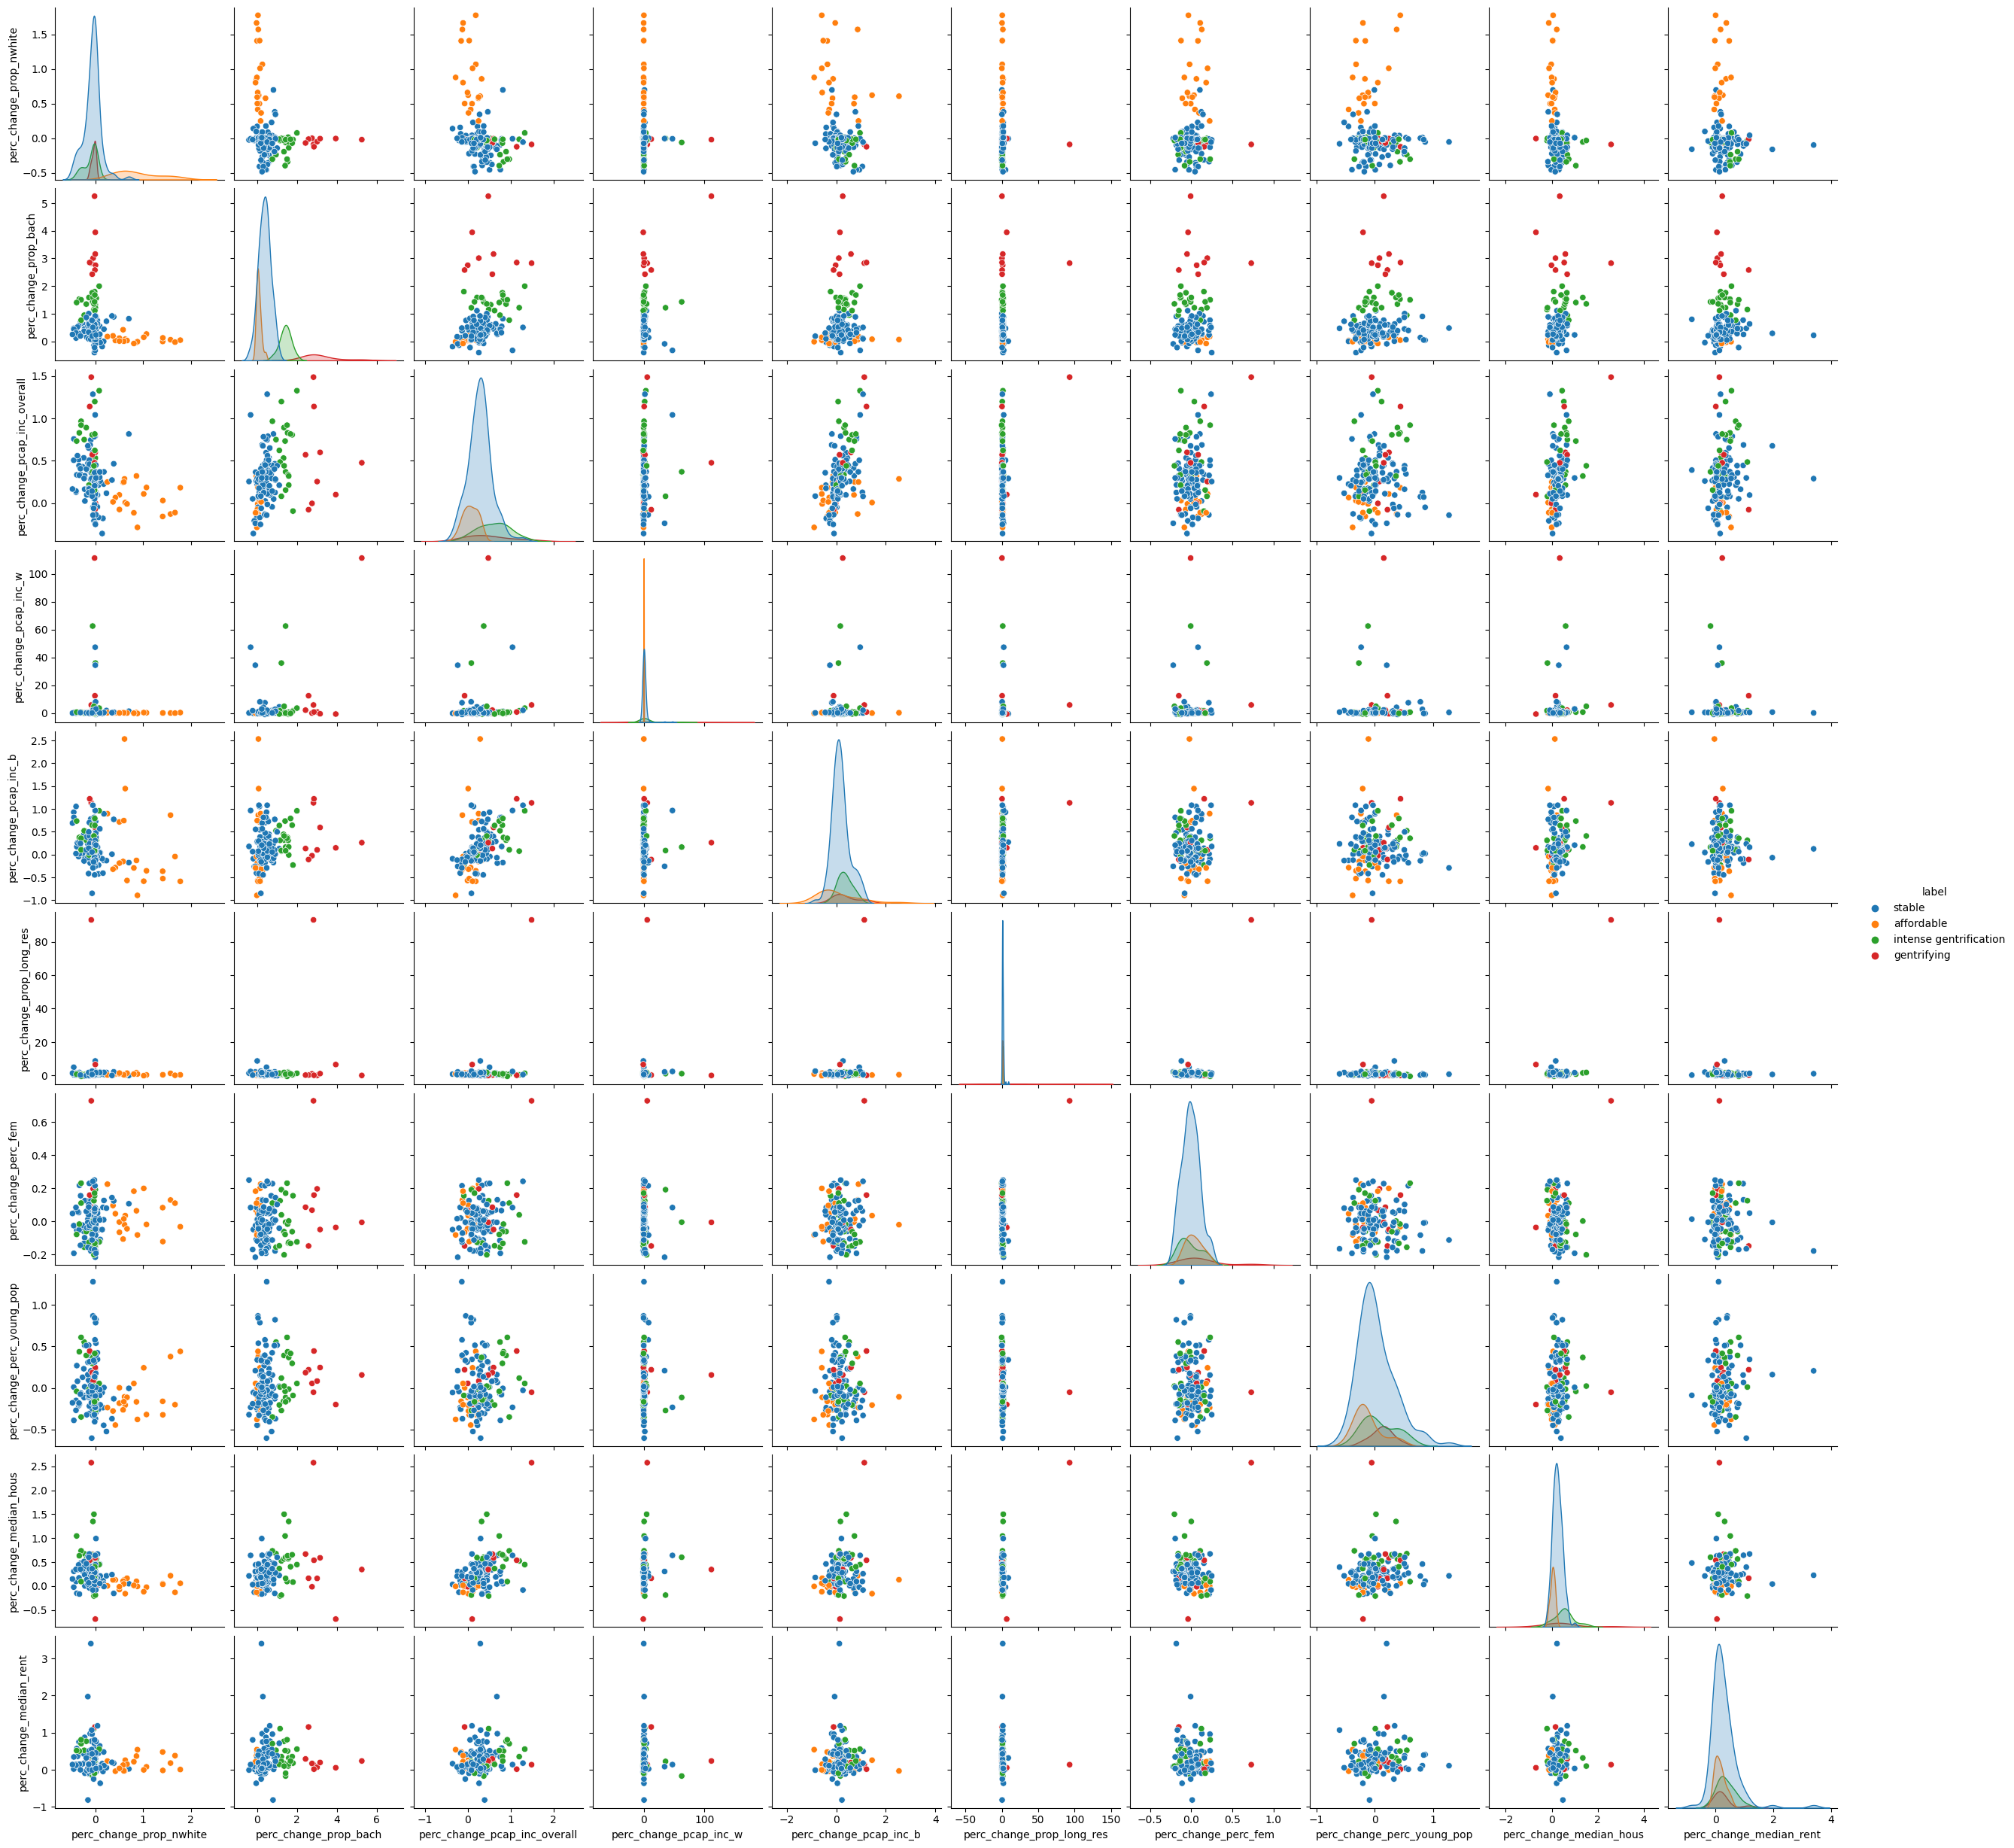

In [16]:
df = acs_final.iloc[:,2:13]
sns.pairplot(df, diag_kind='kde', hue = 'label')  

### Geo mapping by gentrification status

<AxesSubplot: >

(-8586103.193779986, -8560343.574179746, 4690409.992130087, 4722536.728137838)

Text(0.5, 1.0, 'Census Tracts in DC by gentrification status (%change 2012-2021)')

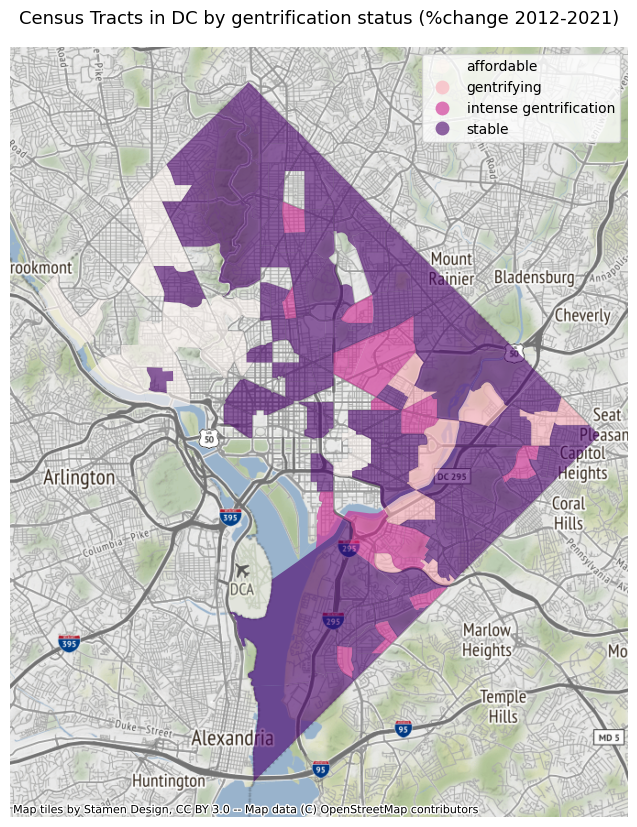

In [17]:
dc_tract = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2019/TRACT/tl_2019_11_tract.zip")
dc_merge = dc_tract.merge(acs_final, left_on = "TRACTCE", right_on = 'tract', how = 'right')
dc_merge_base = dc_merge.to_crs(epsg=3857)


fig, ax = plt.subplots(figsize=(10, 10))

# add the layer with ax=ax in the argument 
dc_merge_base.plot(column = "label",
                       ax = ax,
                       cmap = "RdPu",
                    alpha=0.6,
                       legend = True)
plt.style.use('bmh')
ax.axis('off')

ax.set_title('Census Tracts in DC by gentrification status (%change 2012-2021)',fontsize=13)

ctx.add_basemap(ax)